## **Definición del Problema**
> Debido a la Pandemia que actualmente afronta el mundo, se requiere estimar cómo será la evolución del síndrome respiratorio agudo severo (Covid-19) en los próximos 3 meses en Colombia. Se analizó el comportamiento de las 5 principales ciudades del país, con el fin de generar alertas que permitan tomar decisiones estratégicas tratando de disminuir los impactos que esta pueda generar en la sociedad. Las principales variables a monitorear son la ocurrencia de nuevos casos, los casos activos, los casos confirmados, el número de muertes y el número de recuperados.



## **Definición del Problema de Analítica**

> Se busca estimar el comportamiento futuro de las variables en estudio, sospechando que los contagios continuaran incrementando dado que aún existe una gran porción de la población que no se ha contagiado por primera vez, los contagios acumulados a la fecha son aproximadamente 1,2% del total de la población. Se tiene como variable principal los contagios dado que las otras variables son dependientes de esta.


> Con el fin de estimar el comportamiento de las variables, se realizaron modelos de corto y mediano plazo, basados en la modelación matemática y estadística de los datos reales que se tienen desde el 3 de marzo y que han sido reportados por el Instituto Nacional de Salud (INS) en datos.gov.co.
Los atributos escogidos de las bases de datos del INS son: 

> *  **Ciudad :** Usado para identificar el número de casos por cada ciudad.
*  **Estado :** Usado para clasificar si la persona es un caso activo, recuperado o muerto.
* **Fecha de diagnóstico:** Usado para determinar los casos activos en el tiempo.
*  **Fecha de recuperados:** Usado para determinar los casos recuperados en el tiempo.
*  **Fecha de muerte:** Usado para determinar el número de personas muertas en el tiempo.

> De la página del Departamento Administrativo Nacional de Estadística (DANE), se extrajo las proyecciones poblacionales del 2020 para las cinco principales ciudades del país, como población base para los pronósticos de corto y mediano plazo.











## **Lectura y limpieza de datos**


Se crea una función que realiza consultas a través de API's en datos.gov.co y otra función que lee y limpia un archivo .xlsx con la proyección del DANE de las diferentes edades de la población colombiana por región.

In [2]:
# Librerías

import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import scipy.stats as st
from pmdarima import auto_arima 
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')
import datetime as dt
import math
from sklearn.metrics import mean_squared_error
import pmdarima as pm

In [3]:
import pandas as pd
from sodapy import Socrata

def data(lim):
    
    client = Socrata("www.datos.gov.co", None)
    
    pruebas_api = client.get("8835-5baf", limit=lim)
    df_pruebas = pd.DataFrame.from_records(pruebas_api)
    
    del pruebas_api
    
    casos_api = client.get("gt2j-8ykr", limit=lim)
    df_casos = pd.DataFrame.from_records(casos_api)

    del casos_api
      
    return df_pruebas, df_casos



def poblacion(ruta):
    # Lectura de datos
    df = pd.read_excel(ruta, sheet_name='PPO_GQEdad_DPTO')
    
    # se extraen los códigos de cada departamento
    codigos = df[df['Codigo'].notna()][['Codigo','Grupos de edad']]
    codigos.columns = ['Codigo','Región']
    
    # se llenan los NA con el código inmediatamente anterior
    df['Codigo'] = df['Codigo'].fillna(method='ffill')
    
    # se eliminan las filas de los títulos de los departamentos
    # y las filas del final que traen NA
    df = df.dropna()
    
    # se hace un merge para tener los nombres de los departamentos
    df = pd.merge(df,codigos,on='Codigo',how='left')
    
    return df

In [4]:
#Se definen las funciones con las columnas de datos que seran usadas posteriormente

df_pruebas, df_casos = data(10000000)
df_pob = poblacion('poblacion_municipios.xlsx')
df_pob['Región'] = df_pob['Región'].replace('Bogotá, D.C.', 'Bogotá D.C.')
df_pob['Región'] = df_pob['Región'].replace('Cartagena', 'Cartagena de Indias')
df_casos.columns = ['ID', 'Fecha', 'Cod_Municipio', 'Ciudad', 'Depto', 'Estado', 'Edad', 'Sexo', 'Tipo', 'Gravedad',
                   'Pais_Proc', 'FIS', 'Fecha_Diagnostico', 'Fecha_Recuperado', 'Fecha_Reporte', 'Tipo_Recuperacion', 'Cod_Depto', 
                    'Cod_Pais', 'Etnia', 'Grupo_Etnico', 'Fecha_Muerte']
# se hace una lista con el conteo de casos por ciudad
ciudades = list(df_casos.Ciudad.value_counts().head().index)

Se crea una función que realiza la limpieza de los datos dado el parámetro de la ciudad

Esta función de acuerdo a la ciudad consultada crea un DataFrame resumen cuya columna base son las fechas de inicio de síntomas y en las demás están las variables: Casos totales, muertos, recuperados, salidas (Agrupa muertos y recuperados), casos activos (Casos totales - salidas) y finalmente una variable GR (growth rate, que se calcula como el número de casos nuevos sobre el número de casos activos del día anterior)

In [5]:
def tabla_ciudad(ciudad):

    df = df_casos.loc[(df_casos.Ciudad == ciudad), :]
    df['FIS'] = np.where(df['FIS'] == 'Asintomático',df['Fecha'] ,df['FIS'])
    df['FIS'] = [dt.datetime.combine(dt.datetime.strptime(i,'%Y-%m-%dT%H:%M:%S.%f').date(), dt.datetime.min.time()) for i in df['FIS']]  
    dff = pd.crosstab(df['FIS'], df['Ciudad'])
    dff['Total'] = dff[ciudad].cumsum()
    df_rec = df.loc[(df.Ciudad == ciudad) & ((df.Estado == 'Recuperado') | (df.Estado == 'Fallecido')), :]
    df_recf = pd.crosstab(df_rec['Fecha_Recuperado'], df_rec['Estado'])
    df_m = pd.crosstab(df_rec['Fecha_Muerte'], df_rec['Estado'])
    df_s = pd.merge(df_recf, df_m['Fallecido'], left_index=True, right_index=True, how='left')
    df_s.fillna(0, inplace=True)
    df_s['Salidas'] = df_s.Recuperado + df_s.Fallecido
    dff = pd.merge(dff, df_s, left_index=True, right_index=True, how = 'left')
    dff.fillna(0, inplace=True)
    dff['Salidas_total'] = dff['Salidas'].cumsum()
    dff['Activos'] = dff['Total'] - dff['Salidas_total']
    del df_rec, df_recf
    dff['GR'] = dff[ciudad] / dff['Activos'].shift(1)

    return dff

tabla_ciudad('Medellín').tail()
# La columna medellín tiene el conteo de las personas por fecha de inicio de síntomas

,Medellín,Total,Recuperado,Fallecido,Salidas,Salidas_total,Activos,GR
FIS,,,,,,,,
2020-09-01,105,51488,1210.0,14.0,1224.0,37515.0,13973.0,0.006957
2020-09-02,78,51566,899.0,13.0,912.0,38427.0,13139.0,0.005582
2020-09-03,32,51598,594.0,10.0,604.0,39031.0,12567.0,0.002435
2020-09-04,18,51616,1497.0,11.0,1508.0,40539.0,11077.0,0.001432
2020-09-05,2,51618,690.0,11.0,701.0,41240.0,10378.0,0.000181


## **Metodologías Propuestas**
Inicialmente, después de la limpieza de datos, al observar el comportamiento del total de casos acumulados y de cómo evolucionaban los casos nuevos, se observó que la curva de casos totales se asemeja a una función logística, y los casos nuevos a su derivada. Se realizó una investigación en la literatura para encontrar qué metodologías se han implementado a la fecha tratando de modelar este fenómeno y se encontraron dos funciones que podían ajustarse al comportamiento de los datos.

### **1. Ajuste**

> **El modelo Gompertz** es utilizado cuando un fenómeno biológico está asociado al crecimiento en un determinado tiempo, donde se asume que la tasa de crecimiento se incrementa monotónicamente hasta cuando alcanza un máximo y después decrece en forma monótona asintóticamente.Su ecuación diferencial es: 

>> ![image1.png](attachment:gompertz.png)
 


> **Distribución de Gauss**


>> ![image2.png](attachment:gauss.png)


> Se realizó el ajuste de ambas curvas utilizando la función de optimización curve_fit() de scipy.optimize, que utiliza un el método Levenberg-Marquardt, que interpola entre el algoritmo de Gauss-Newton (GNA) y el método de gradiente descendente.





Para realizar el ajuste se ejecutó un ciclo que optimiza ambas curvas para los datos de cada una de las principales 5 ciudades de Colombia.

Para ilustrar el procedimiento utlizaremos la ciudad de medellín

In [6]:
c = 'Medellín'

# número de pronósticos
pred = 45
# datos para la validación cruzada
val_cruz = 7

# Se filtra el df por ciudad
df = tabla_ciudad(c)
df.index = pd.to_datetime(df.index)

# Total de datos
N = df.shape[0]

# Serie completa (Ajuste y pronóstico)
x = np.arange(0, N)
pred_x = np.arange(N, N + pred)    

#Validación cruzada (Ajuste y pronóstico)
x_val = np.arange(0, N - val_cruz)
pred_x_val = np.arange(N - val_cruz, N)
    

Se definen las funciones que se ajustarán a los datos

Gompertz: Para los casos totales
Derivada Gompertz, Gauss: Para las demás variables

In [7]:
#Modelo Gompertz casos totales
def gompertz(x, a, b, c):
    return c * np.exp(-b * np.exp(-x / a))
# Modelo Gompertz casos nuevos (Derivada)
def f_gompertz(x, a, b, c):
    return (a * (-b) * (-c) * np.exp(-b * np.exp(-c * x)) * np.exp(-c * x))
def gauss(x, s,u,c):
    return (1/(s*math.sqrt(2*math.pi)))*np.exp((-1*(x-u)**2)/(2*s**2))*c

- Para los casos nuevos se ajustan las dos funciones
- Se toma como variable la fecha de inicio de síntomas.
- Se retiran los últimos 7 datos, ya que los enfermos que están teniendo síntomas la última semana serán registrados en los próximos días en la base de datos

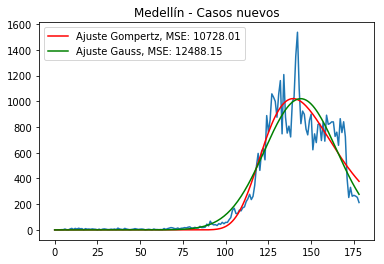

In [8]:
# Variable independiente
f_y = np.array(df[c][:-7])

# Gompertz
f_param, pcov = curve_fit(f_gompertz, x[:-7], f_y, maxfev=10000000)
ajuste_gompertz = f_gompertz(x[:-7], *f_param)
pronostico_gompertz = f_gompertz(pred_x-7, *f_param)

# Gauss
f_param2, pcov2 = curve_fit(gauss, x[:-7], f_y, maxfev=10000000, bounds=([10,100,1000],[10000,10000,10000000]))
ajuste_gauss = gauss(x[:-7], *f_param2)
pronostico_gauss = gauss(pred_x-7, *f_param2)


# MSE (sklearn)
mse1 = mean_squared_error(f_y,ajuste_gompertz)
mse2 = mean_squared_error(f_y,ajuste_gauss)


plt.plot(f_y)
plt.plot(ajuste_gompertz, 'r-', label = f'Ajuste Gompertz, MSE: {round(mse1,2)}')
plt.plot(ajuste_gauss, 'g-', label = f'Ajuste Gauss, MSE: {round(mse2,2)}')
plt.title('Medellín - Casos nuevos')
plt.legend()
plt.show()

Se observó que similar al caso de Medellín las demás variables también mostraban diferentes ajustes con ambas curvas, por lo que se decidió que para cada variable y ciudad se tomaría aquella curva con mejor ajuste, como criterio de selección se utilizó el MSE.

Para modelar las variables en el ciclo de forma más simple se utilizó la siguiente función, que devuelve el ajuste y el pronóstico del modelo que mejor ajusta.

In [9]:
def mod_gompertz(y, x, pred_x, tipo='nuevos'):

    y = list(y)

    #Modelo Gompertz casos totales
    def gompertz(x, a, b, c):
        return c * np.exp(-b * np.exp(-x / a))
    # Modelo Gompertz casos nuevos (Derivada)
    def f_gompertz(x, a, b, c):
        return (a * (-b) * (-c) * np.exp(-b * np.exp(-c * x)) * np.exp(-c * x))
    def gauss(x, s,u,c):
        return (1/(s*math.sqrt(2*math.pi)))*np.exp((-1*(x-u)**2)/(2*s**2))*c
    

    # Ajuste y pronóstico
    if tipo == 'nuevos':
        f_param, pcov = curve_fit(f_gompertz, x, y, maxfev=10000000)
        ajuste = f_gompertz(x, *f_param)
        pronostico = f_gompertz(pred_x, *f_param)
        f_param2, pcov2 = curve_fit(gauss, x, y, maxfev=10000000, bounds=([10,100,1000],[10000,10000,10000000]))
        ajuste2 = gauss(x, *f_param2)
        pronostico2 = gauss(pred_x, *f_param2)
        
        # MSE (sklearn)
        mse1 = mean_squared_error(y,ajuste)
        mse2 = mean_squared_error(y,ajuste2)
        
        # Se selecciona la de menor MSE
        if mse2 <= mse1:
            ajuste = ajuste2
            pronostico = pronostico2

        
    elif tipo == 'totales':
        # Para los casos totales solamente se utilizó la función gompertz
        param, pcov = curve_fit(gompertz, x, y, maxfev=10000000)
        ajuste = gompertz(x, *param)
        pronostico = gompertz(pred_x, *param)
        

        ajuste2 = np.repeat(0,len(x))
        pronostico2 = np.repeat(0,len(pred_x))
    else:
        print('Elija un tipo válido')
        
        
    
    return ajuste, pronostico


> Al observar el comportamiento de las curvas se analizaron los residuales y se encontró que estos contenían correlaciones que podían ser modeladas a través de Modelos Autorregresivos y de Medias Móviles (ARMA).

> No fue necesario realizar diferenciación en los residuales ya que la tendencia es modelada por las funciones Gompertz o Gauss.









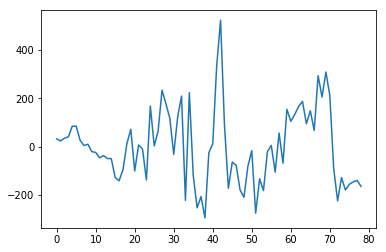

In [11]:
# por mse se toma el ajuste Gompertz (Variable "ajuste")

# se hallan los residuales
res = f_y - ajuste_gompertz

# Se grafican los residuales sin tener en cuenta los primeros periodos donde la serie es casi constante cercana a cero
plt.plot(res[100:])
plt.show()

En los residuales se observa una varianza aproximadamente constante y que tienen media cero (No hay presencia de tendencia)

Se grafica la ACF y la PACF en busca de correlaciones significativas

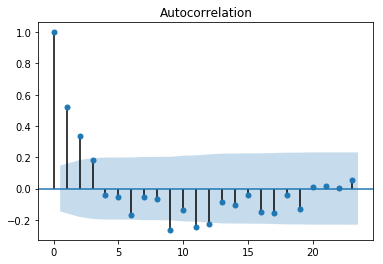

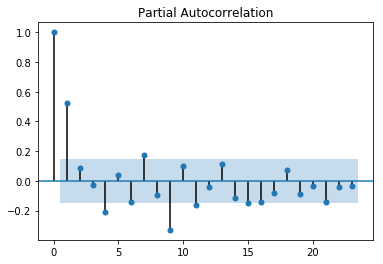

In [12]:
pm.plot_acf(res, alpha = 0.05)
pm.plot_pacf(res, alpha = 0.05)

Se observan correlaciones significativas para los rezagos 1 y 2 en la ACF y el rezago 1 y 9 en la PACF. Adicionalmente la serie de los residuales sigue un proceso estacionario en covarianza ya que tiene media cero, varianza aproximadamente constante y tiene propiedades ergódicas (La autocorrelación tiende a cero rápidamente) 

In [13]:
# Para el ajuste se utiliza la función auto_arima de la librería pmdarima
# Esta función prueba modelos ARMA de diferentes órdenes y por medio de un algorítmo
# encuentra el modelo con menor AIC

# De esta manera podemos automatizar la búsqueda de modelos para cada variable
# Estas series no muestran un patrón estacional determinístico periodico exacto,
# por lo que a la función se le asigna seasonal = False
stepwise_fit = auto_arima(res, seasonal=False)


# # se ajusta el modelo con la función SARIMAX de statsmodels
arma = SARIMAX(res,order=stepwise_fit.order)

# se hace el fit
resultado = arma.fit() 



# Con predict se genera un vector con los ajustes para los residuales
ajuste_ARMA = resultado.predict(1, len(res), 
                      typ = 'levels')

pronostico_ARMA = resultado.predict(min(pred_x-7), max(pred_x-7), 
                      typ = 'levels')

# Resumen del modelo
resultado.summary() 



<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  179
Model:               SARIMAX(3, 0, 2)   Log Likelihood               -1043.718
Date:                Mon, 07 Sep 2020   AIC                           2099.437
Time:                        22:35:10   BIC                           2118.561
Sample:                             0   HQIC                          2107.192
                                - 179                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9103      0.060    -15.139      0.000      -1.028      -0.792
ar.L2          0.0101      0.066      0.152      0.879      -0.120       0.140
ar.L3          0.6027      0.040     15.110      0.000       0.524       0.681
ma.L1          1.4584      0.057     25.790      0.000       1.348       1.569
ma.L2          0.8516      0.057     15.001      0.000       0.740       0.963
sigma2      6746.9965    375.223     17.981      0.000    6011.574    7482.419
===================================================================================
Ljung-Box (Q):                       57.83   Jarque-Bera (JB):               243.07
Prob(Q):                              0.03   Prob(JB):                         0.00
Heteroskedasticity (H):            1044.95   Skew:                            -0.06
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

El modelo con mejor ajuste en este caso es un ARIMA(3,0,2), según el valor-p sólo el parámetro phi2 no es significativo.

Ahora se combinan los dos ajustes (tendencia Gompertz y ARIMA para ciclos en los residuales)

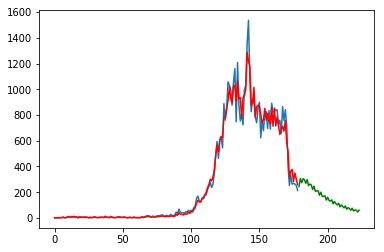

In [14]:
ajuste_final = ajuste_gompertz + ajuste_ARMA
pronostico_final = pronostico_gompertz + pronostico_ARMA

plt.plot(f_y)
plt.plot(x[:-7],ajuste_final, 'r-')
plt.plot(pred_x-7,pronostico_final, 'g-')

Se observa que con el modelo ARMA en los ciclos de los residuales se logra explicar parte de la variación de la serie (En algunas variables logra explicar más que otras)


### **2. Pronóstico**

> Para realizar los pronósticos de acuerdo a la información disponible y los modelos de ajuste previamente explicados se tomaron tres escenarios que tienen como base las medidas tomadas por los gobiernos en cuanto a restricciones de movilidad y el grado de apertura a extranjeros o residentes que se encontraban afuera del país.

>**Escenario Restricciones Estrictas (Base)**: Este escenario se plantea teniendo en cuenta la gestión que se hizo en Colombia desde finales de marzo hasta el 31 de agosto de 2020. De forma generalizada se evidencian restricciones estrictas a la movilidad y cierre total de los aeropuertos y por lo tanto entrada de personas que estuvieran fuera del país. Para este escenario el prónostico se lleva a cabo con el modelo ajustado a la función Gompertz o Gauss y los parámetros optimizados de acuerdo a la información disponible.

> **Escenario Restricciones Parciales (Estrés moderado)**: En este escenario se plantea una reapertura parcial de las restricciones a la movilidad y apertura a la entrada de personas provenientes del exterior, sin embargo, se continuan exigiendo muchos protocolos de bioseguridad en todas las interacciones y lugares públicos. Para realizar este pronóstico se toman 15 días del modelo ajustado a la función Gompertz o Gauss (15 días es el tiempo promedio observado de cambios de tendencia en el numero de casos en una región ante cambios en las políticas) y a partir del día 16 hasta el 45 se complementa con un modelo **SIR** con parámetros Beta (ratio de propagación) y Gamma (ratio de recuperación) como los presentados en USA, país que ha mantenido una política simílar a la planteada en el escenario.

>**Escenario Sin Restricciones (Alto Estrés)**: En este escenario se plantea una apertura total de las restricciones a la movilidad y apertura total de turistas y extranjeros al país. Los protocolos de bioseguridad no son obligatorios y solo algunas cuestiones puntuales de la vida pública estan limítadas al acceso ciudadano. Para realizar este pronóstico se toman 15 días del modelo ajustado a la función Gompertz o Gauss (15 días es el tiempo promedio observado de cambios de tendencia en el numero de casos en una región ante cambios en las políticas) y a partir del día 16 hasta el 45 se complementa con un modelo **SIR** con parámetros Beta (ratio de propagación) y Gamma (ratio de recuperación) como los presentados en Mexico, país que ha mantenido una política simílar a la planteada en el escenario.

> **El modelo SIR** funciona bajo el supuesto de que toda la población de un territorio es susceptible **(S)** y tiene alta probabilidad de contagiarse y por esto la población infectada **(I)** se incrementa exponencialmente en un periodo de tiempo determinado y a partir de estos se generan los casos recuperados y fallecidos **(R)**. Para el incremento y disminución de los casos contagiados se utiliza la Beta **(β)** como la tasa de contagio y Gamma **(Γ)** como la tasa de recuperación. El modelo SIR consta de un sistema de tres ecuaciones diferenciales:

>> 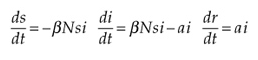



In [15]:
#Modelo SIR
#Definicion de variables a Usar para el modelo SIR
# Se define N como la población por ciudad.
# Se dan los parametros iniciales para la población infectada y recuperada
# Se define S como la población suceptible de infectarse
# Se define el horizonte de tiempo "t" como el tamaño de la tabla ciudad (dias) + el numero de dias de la predicción
def SIR(ciudad, df_pob, n_pred, beta, gamma):

    df = tabla_ciudad(c)
    N = int(df_pob.loc[(df_pob['Grupos de edad'] == 'Total') & (df_pob['Región'] == c), ['Ambos Sexos']].sum() * 0.6)
    I0, R0 = df['Total'][-1], df['Recuperado'].sum()
    S0 = N - I0 - R0
    t = np.linspace(df.shape[0] + 1, df.shape[0] + n_pred, n_pred)
    
    
    #Se Calcula primera derivada de los casos suceptibles, infectados y recuperados. Para hallar las variaciones.
    def deriv(y, t, N, beta, gamma):
        S, I, R = y
        dSdt = -beta * S * I / N
        dIdt = beta * S * I / N - gamma * I
        dRdt = gamma * I
        return dSdt, dIdt, dRdt
    
    #Se definen los datos iniciales para Infectados, recuperados y suceptibles
    y0 = S0, I0, R0
    ret = odeint(deriv, y0, t, args=(N, beta, gamma))
    S, I, R = ret.T
    return S, I, R

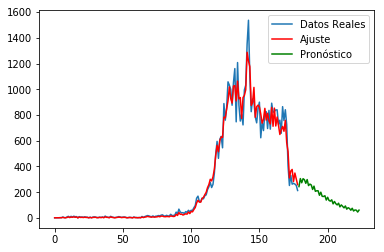

In [18]:
#Pronostico Escenario Restricciones Estrictas --> Medellín
ajuste_final = ajuste_gompertz + ajuste_ARMA
pronostico_final = pronostico_gompertz + pronostico_ARMA

plt.plot(f_y, label='Datos Reales')
plt.plot(x[:-7],ajuste_final, 'r-', label='Ajuste')
plt.plot(pred_x-7,pronostico_final, 'g-', label='Pronóstico')
plt.legend()
plt.show()

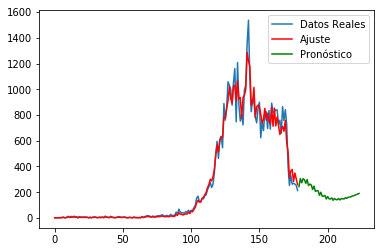

In [20]:
#Pronostico Escenario Restricciones Parciales --> Medellín
Se, Ie, Re = SIR(c, df_pob, pred, 0.0167,0.0121)  
SIR_n_u = [0 if i < 0 else i for i in np.diff(Ie)]
SIR_n_u = [0] + SIR_n_u
p = np.linspace(0, 1, 30)
pron_final_usa = pronostico_final[15:]*(1-p) + SIR_n_u[15:]*p
pron_final_usa = np.append(pronostico_final[:15], pron_final_usa)

plt.plot(f_y, label='Datos Reales')
plt.plot(x[:-7],ajuste_final, 'r-', label='Ajuste')
plt.plot(pred_x-7,pron_final_usa, 'g-', label='Pronóstico')
plt.legend()
plt.show()

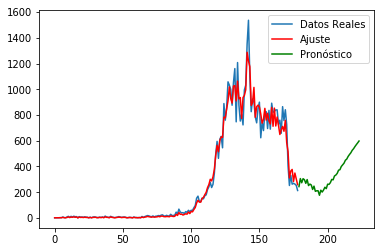

In [21]:
#Pronostico Escenario Sin Restricciones --> Medellín
Sm, Im, Rm = SIR(c, df_pob, pred, 0.0515,0.0364)  
SIR_n_m = [0 if i < 0 else i for i in np.diff(Im)]
SIR_n_m = [0] + SIR_n_m
p = np.linspace(0, 1, 30)
pron_final_mex = pronostico_final[15:]*(1-p) + SIR_n_m[15:]*p
pron_final_mex = np.append(pronostico_final[:15], pron_final_mex)

plt.plot(f_y, label='Datos Reales')
plt.plot(x[:-7],ajuste_final, 'r-', label='Ajuste')
plt.plot(pred_x-7,pron_final_mex, 'g-', label='Pronóstico')
plt.legend()
plt.show()

>Los tres escenarios planteados anteriormente se grafican para la variable Casos Nuevos, para visualizar el pronóstico de las demás variables y sus respectivos intervalos remitirse al Dashboard de este trabajo: https://teamap-unal.herokuapp.com/

### **3. Despliegue de los resultados (producto de datos)**

>La metodología implementada para la realización del Dashboard como producto final, es a tráves de la librería Dash de python y sus complementos dash_core_components y dash_bootstrap_components. Para visualizar este esquema por favor remitirse al archivo "dash_v2.py" en esta ruta.

### **4. Gestión del ciclo de vida del producto de datos**

>Para mantener el producto de datos actualizado de acuerdo a la información disponible en www.datos.gov.co se ejecuta un archivo .bat de forma diaria en un servidor. En este archivo primero se ejecuta casos.py, actualizar_modelos.py para actualizar las bases de datos que se implementan que utilizando los servicios de www.heroku.com 